In [492]:
import simpy
from mylibrary import MonitoredResource
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as snd
snd.set(rc={'figure.figsize':(15,8.27)})
cashierWaitTime = []
stationWaitTime = []
cashierUsersY = []
cashierUsersX = []
stationUsersY = []
stationUsersX = []
stationUtilizationX = []
stationUtilizationY = []
cashierUtilizationX = []
cashierUtilizationY = []
stationBusyPeriod = []
cashierBusyPeriod = []
percievedWaitTime = []
log = []
plt.figure(num=None, figsize=(20, 20))
SIMULATIONTIME = 600
CASHIERSERVICERATE = 2.142
STATIONSERVICERATE = 2.109
ARRIVALRATE =  3.342
ORDERRATE = 2.142
PAYMENTRATE = 2.142-0.5
RANDOM_SEED = 37
np.random.seed(RANDOM_SEED)

<Figure size 1440x1440 with 0 Axes>

In [493]:
class Cafe:
    def __init__(self, env):
        self.cashier = MonitoredResource(env, capacity=1)
        self.station = MonitoredResource(env, capacity=1)

In [494]:
def Order(name, env, cafe, serviceRate):
    print('Order %s is heard at %s' % (name, env.now))
    order_name = 'Order ' + str(name)
    log.append({'Time': env.now, 'Entity': order_name, 'Event': 'Enters'})
    tempWaitTime = env.now
    serviceTime = np.random.exponential(serviceRate)
    stationUsersY.append( len(cafe.station.users))
    stationUsersX.append(env.now)
    with cafe.station.request() as req:
        yield req
        tempBusyTime = env.now
        stationUtilizationX.append(env.now)
        stationUtilizationY.append(1)
        stationWaitTime.append(env.now - tempWaitTime)
        print('Staff starts to make the order %s at %s' % (name, env.now))
        log.append({'Time': env.now, 'Entity': order_name, 'Event': 'Processing'})
        yield env.timeout(serviceTime)
        print('Stafff finish making order %s  at %s' % (name, env.now))
        stationBusyPeriod.append(env.now - tempBusyTime)
        stationUsersY.append(len(cafe.station.queue) + len(cafe.station.users))
        stationUsersX.append(env.now)
        percievedWaitTime[name] = env.now - percievedWaitTime[name]
        log.append({'Time': env.now, 'Entity': order_name, 'Event': 'Leaves'})
        if len(cafe.station.queue) == 0:
            stationUtilizationX.append(env.now)
            stationUtilizationY.append(0)

In [495]:
def Customer(name, env, cafe, orderRate, paymentRate, stationServiceRate):
    customer_name = 'Customer ' + str(name)
    print('Customer %s arriving at %s' % (name, env.now))
    log.append({'Time': env.now, 'Entity': customer_name, 'Event': 'Enters'})
    tempWaitTime = env.now
    percievedWaitTime.append(env.now)
    cashierUsersY.append(len(cafe.cashier.users))
    cashierUsersX.append(env.now)
    orderTime = np.random.exponential(2.142)
    with cafe.cashier.request() as req:
        yield req
        tempBusyTime = env.now
        cashierUtilizationX.append(env.now)
        cashierUtilizationY.append(1)
        cashierWaitTime.append(env.now - tempWaitTime)
        print('Customer %s starts to order at %s' % (name, env.now))
        log.append({'Time': env.now, 'Entity': customer_name, 'Event': 'Processing'})
        yield env.timeout(orderTime)
        print('Customer %s done with ordering at %s' % (name, env.now))
        env.process(Order(name, env, cafe, stationServiceRate))
        log.append({'Time': env.now, 'Entity': customer_name, 'Event': 'Leaves'})
        cashierUsersY.append(len(cafe.cashier.queue) + len(cafe.cashier.users))
        cashierUsersX.append(env.now)
        cashierBusyPeriod.append(env.now - tempBusyTime)
        if len(cafe.cashier.queue) == 0:
            cashierUtilizationX.append(env.now)
            cashierUtilizationY.append(0)

In [496]:
def CustomerGenerator(env, cafe, arrivalRate, orderRate, paymentRate, stationServiceRate):
    i = 0
    while env.now < SIMULATIONTIME:
        interArrivalTime = np.random.exponential(arrivalRate)
        env.process(Customer(i, env, cafe, orderRate, paymentRate, stationServiceRate))
        i += 1
        yield env.timeout(interArrivalTime)

In [497]:
env = simpy.Environment()
coffee_world = Cafe(env)
customer_gen = env.process(CustomerGenerator(env, coffee_world, ARRIVALRATE, ORDERRATE, PAYMENTRATE, STATIONSERVICERATE))
env.run(SIMULATIONTIME)


Customer 0 arriving at 0
Customer 0 starts to order at 0
Customer 0 done with ordering at 1.336188801395929
Order 0 is heard at 1.336188801395929
Staff starts to make the order 0 at 1.336188801395929
Stafff finish making order 0  at 1.7878894685856381
Customer 1 arriving at 9.662761530185266
Customer 1 starts to order at 9.662761530185266
Customer 1 done with ordering at 11.735801246493844
Order 1 is heard at 11.735801246493844
Staff starts to make the order 1 at 11.735801246493844
Customer 2 arriving at 12.577060348736195
Customer 2 starts to order at 12.577060348736195
Customer 3 arriving at 12.941964419546293
Customer 4 arriving at 14.04902384321448
Stafff finish making order 1  at 14.1668924355064
Customer 2 done with ordering at 15.508085812195793
Order 2 is heard at 15.508085812195793
Staff starts to make the order 2 at 15.508085812195793
Customer 3 starts to order at 15.508085812195793
Stafff finish making order 2  at 16.744103353580208
Customer 3 done with ordering at 18.507073

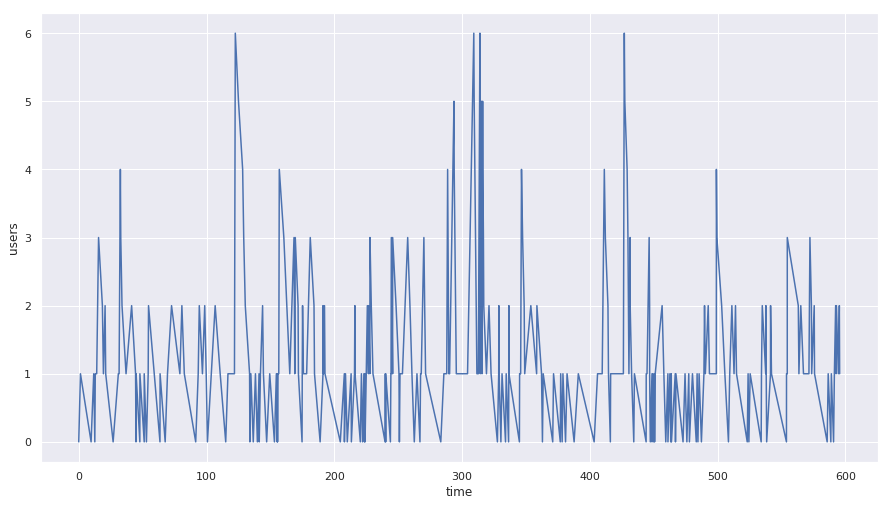

In [498]:
df = pd.DataFrame()
df['time'] = cashierUsersX
df['users'] = cashierUsersY
ax = snd.lineplot(x="time", y="users", data=df)

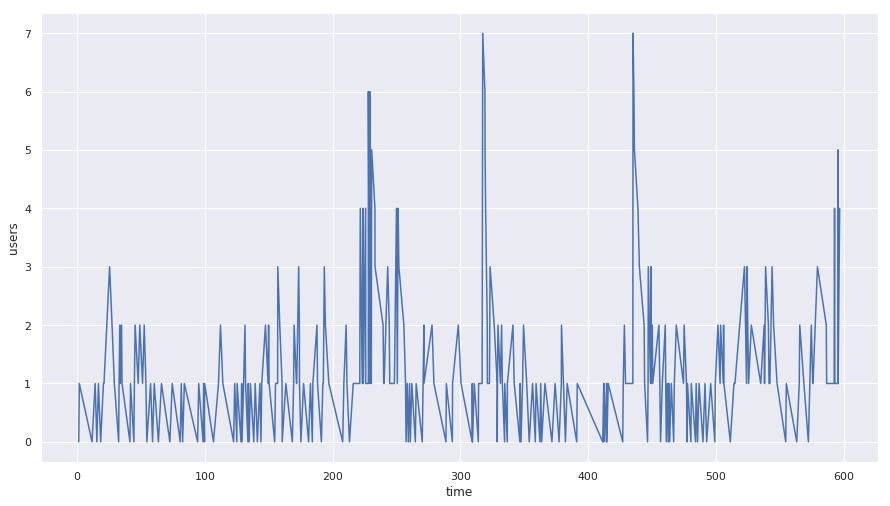

In [499]:
df = pd.DataFrame()
df['time'] = stationUsersX
df['users'] = stationUsersY
ax = snd.lineplot(x="time", y="users", data=df)

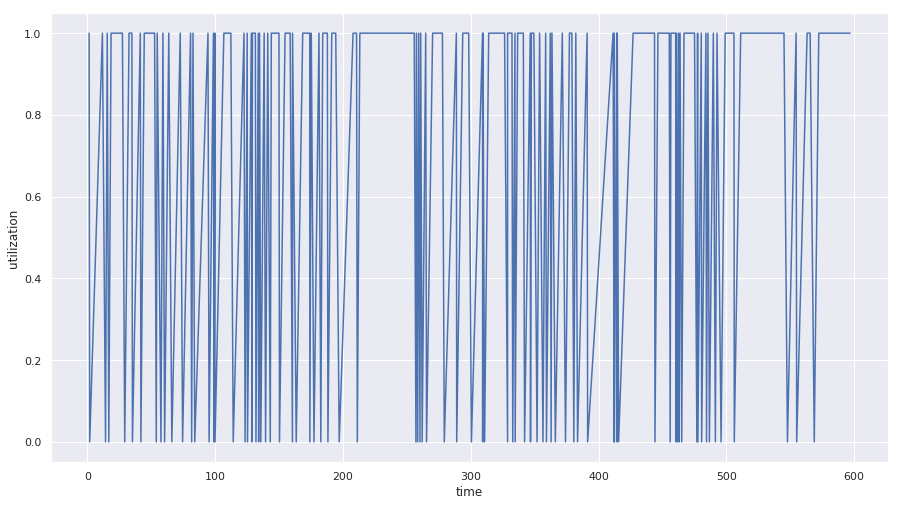

In [500]:
df = pd.DataFrame()
df['time'] = stationUtilizationX
df['utilization'] = stationUtilizationY
ax = snd.lineplot(x="time", y="utilization", data=df)

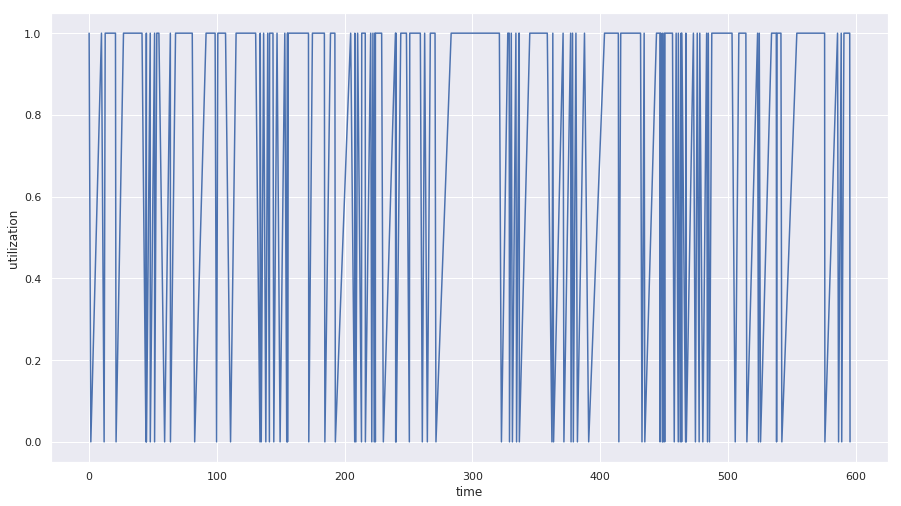

In [501]:
df = pd.DataFrame()
df['time'] = cashierUtilizationX
df['utilization'] = cashierUtilizationY
ax = snd.lineplot(x="time", y="utilization", data=df)

In [502]:
cashier_utilization = sum(cashierBusyPeriod)/SIMULATIONTIME
print(cashier_utilization)
station_utilization = sum(stationBusyPeriod)/SIMULATIONTIME
print(station_utilization)

0.5885806994323515
0.5463193658355174


In [503]:
averageCashierWaitTime = sum(cashierWaitTime)/len(cashierWaitTime)
print(averageCashierWaitTime)
averageStationWaitTime = sum(stationWaitTime)/len(stationWaitTime)
print(averageStationWaitTime)

2.1323622120372363
1.7169818737811409


In [504]:
cleanPercievedWaitTime = [waitTime for waitTime in percievedWaitTime if waitTime < 100]
averagePercievedWaitTime = sum(cleanPercievedWaitTime)/len(cleanPercievedWaitTime)
print(averagePercievedWaitTime)
event_log = pd.DataFrame(data=log)
event_log.to_csv('Original_Log', sep=',', encoding='utf-8')


7.946614426692903


In [505]:
print(sum(stationUsersY)/len(stationUsersY))
print(sum(cashierUsersY)/len(cashierUsersY))

1.2597014925373133
1.2751479289940828
